In [1]:
from __future__ import print_function
import copy
# import cProfile, pstats, StringIO
import iminuit
# %load_ext ipycache
%load_ext line_profiler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from multiprocessing import Pool
import numba
import numpy as np
import os
import pandas as pd
import pymp
import random
import scipy as sp
from scipy import optimize
from scipy import stats
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
import atm_c14_data
import c14_models
import c14_individuals_data

# reload(atm_c14_data)
# reload(c14_models)
# reload(c14_individuals_data);

In [3]:
def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

In [4]:
Klag = atm_c14_data.Klag
K = atm_c14_data.K
C = c14_models.C_scenario_A
C2 = c14_models.C_scenario_2POP

In [5]:
c14_patient_data = c14_individuals_data.c14_individual_data

In [6]:
hepatocyte_data = c14_individuals_data.c14_individual_data.query('type == "hepatocyte"')
hepatocyte_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


# EDA

## Atmospheric 14C

In [7]:
c14_data = atm_c14_data.c14_data

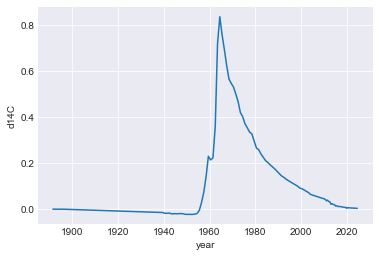

In [8]:
plt.figure()
plt.plot(c14_data['year'], c14_data['d14C'])
plt.xlabel('year')
plt.ylabel('d14C')
plt.show()

## Patient data

In [9]:
sns.set_context('talk')

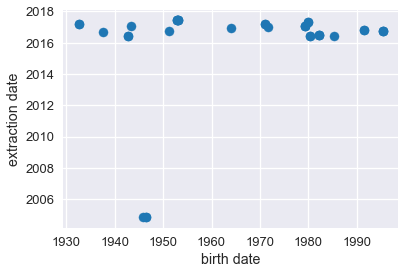

In [10]:
plt.figure()
plt.scatter(c14_patient_data['Dbirth'], c14_patient_data['Dcoll'])
plt.xlabel('birth date')
plt.ylabel('extraction date')
plt.savefig('plots/sample_dates.svg', bbox_inches='tight')
plt.show()

### Hepatocyte data

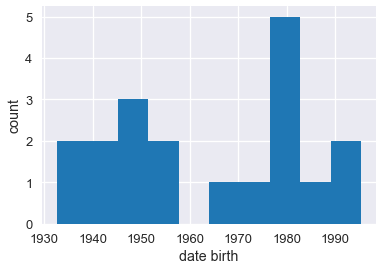

In [11]:
plt.figure()
plt.hist(hepatocyte_data['Dbirth'])
plt.xlabel('date birth')
plt.ylabel('count')
plt.show()

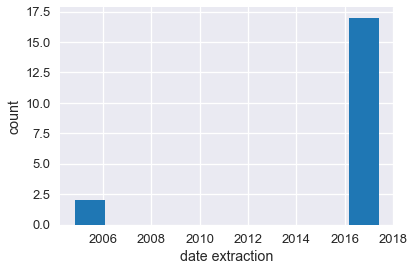

In [12]:
plt.figure()
plt.hist(hepatocyte_data['Dcoll'])
plt.xlabel('date extraction')
plt.ylabel('count')
plt.show()

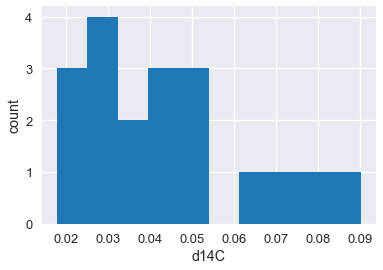

In [13]:
plt.figure()
plt.hist(hepatocyte_data['d14C'])
plt.xlabel('d14C')
plt.ylabel('count')
plt.show()

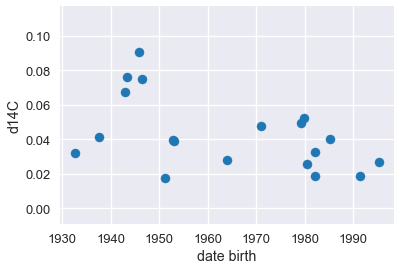

In [14]:
plt.figure()
plt.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'])
plt.xlabel('date birth')
plt.ylabel('d14C')
plt.show()

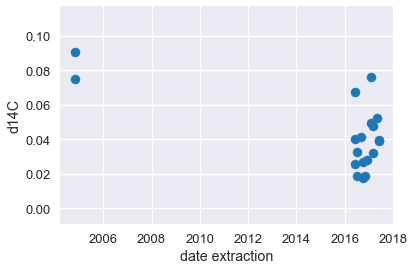

In [15]:
plt.figure()
plt.scatter(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'])
plt.xlabel('date extraction')
plt.ylabel('d14C')
plt.show()

## Correlation atmospheric 14C at patient dates and 14C DNA concentration

Define helper function to get atmospheric 14C at given date

In [16]:
c14_atm = atm_c14_data.K

In [17]:
c14_atm(2000)

0.08829999999999995

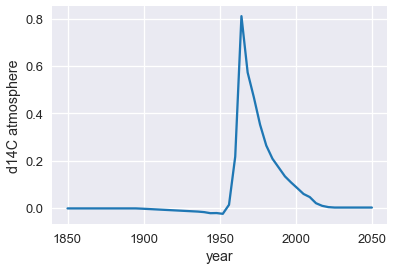

In [18]:
plt.figure()
time = sp.linspace(1850, 2050)
plt.plot(time, c14_atm(time))
plt.xlabel('year')
plt.ylabel('d14C atmosphere')
plt.show()

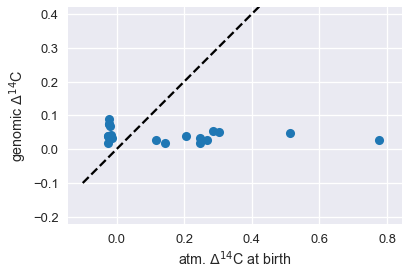

In [43]:
plt.plot(c14_atm(hepatocyte_data['Dbirth']), hepatocyte_data['d14C'], ls='None',marker='o')
x = sp.linspace(-0.1, 0.8)
plt.plot(x, x, 'k--')
plt.xlabel('atm. $\Delta^{14}$C at birth')
plt.ylabel('genomic $\Delta^{14}$C')
plt.axis('equal')
plt.ylim(0, 0.2)
plt.savefig('plots/correlation_birth_gene.svg', bbox_inches='tight')
plt.show()

In [37]:
sp.stats.pearsonr(c14_atm(hepatocyte_data['Dbirth']), hepatocyte_data['d14C'])

(-0.31109100565298503, 0.19483448300280234)

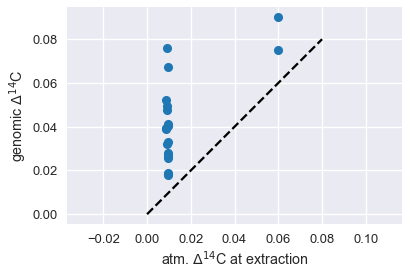

In [42]:
plt.plot(c14_atm(hepatocyte_data['Dcoll']), hepatocyte_data['d14C'], ls='None',marker='o')
x = sp.linspace(0, 0.08)
plt.plot(x, x, 'k--')
plt.xlabel('atm. $\Delta^{14}$C at extraction')
plt.ylabel('genomic $\Delta^{14}$C')
plt.axis('equal')
plt.savefig('plots/correlation_extraction_gene.svg', bbox_inches='tight')
plt.show()

In [21]:
sp.stats.pearsonr(c14_atm(hepatocyte_data['Dcoll']), 
            hepatocyte_data['d14C'])

(0.65811738794936825, 0.0021899322969040689)

Only where atmospheric 14C data available:

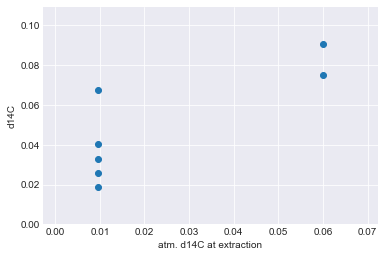

In [22]:
plot_data = hepatocyte_data.query('Dcoll < 2016.6')
plt.scatter(c14_atm(plot_data['Dcoll']), 
            plot_data['d14C'])
plt.xlabel('atm. d14C at extraction')
plt.ylabel('d14C')
plt.show()

In [23]:
sp.stats.pearsonr(c14_atm(plot_data['Dcoll']), 
            plot_data['d14C'])

(0.81222716882565527, 0.026447808831580467)

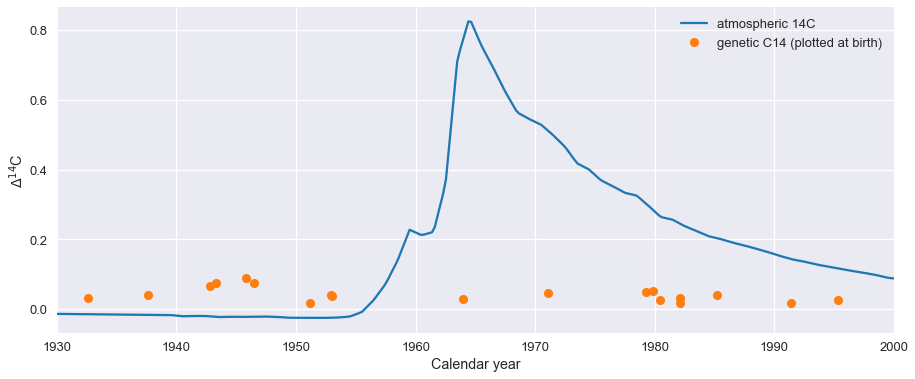

In [98]:
plt.figure( figsize=(15, 6) )
time = sp.linspace(1930, 2000, 300)
plt.plot(time, c14_atm(time), label='atmospheric 14C')

plt.plot(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], ls='None', marker='o', 
         label='genetic C14 (plotted at birth)')

plt.xlim(1930, 2000)
#plt.ylim(0, 0.1)

plt.xlabel('Calendar year')
plt.ylabel('$\Delta^{14}$C')

plt.legend(loc='best')

plt.savefig('plots/C14_at_birth.svg', bbox_inches='tight')
plt.savefig('plots/C14_at_birth.png', bbox_inches='tight', dpi=300)

plt.show()

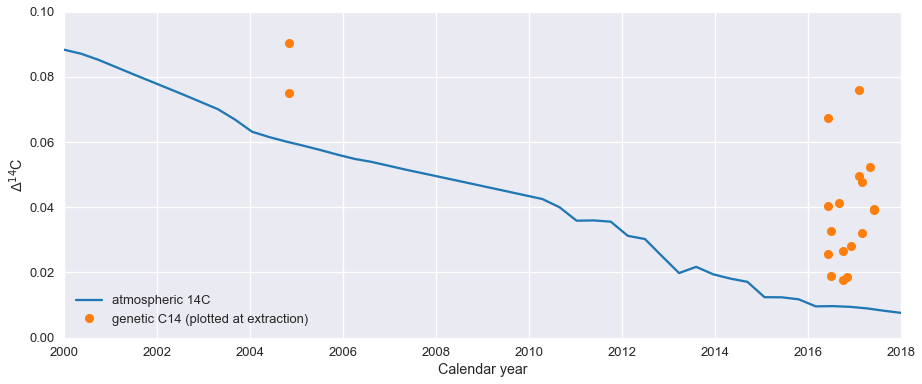

In [99]:
plt.figure( figsize=(15, 6) )
time = sp.linspace(2000, 2018)
plt.plot(time, c14_atm(time), label='atmospheric 14C')

plt.plot(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'], ls='None', marker='o', 
         label='genetic C14 (plotted at extraction)')

plt.xlim(2000, 2018)
plt.ylim(0, 0.1)

plt.xlabel('Calendar year')
plt.ylabel('$\Delta^{14}$C')

plt.legend(loc='lower left')

plt.savefig('plots/C14_at_coll.svg', bbox_inches='tight')

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

for ax in axs:
    time = sp.linspace(1850, 2050)
    ax.plot(time, c14_atm(time), label='atmospheric 14C')

    ax.plot(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'], ls='None', marker='o', label='genetic C14')

    ax.set_ylim(0, 0.1)

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()

axs[0].set_xlim(2004, 2006)
axs[1].set_xlim(2016, 2018)
    
plt.savefig('plots/C14_at_coll.svg', bbox_inches='tight')

plt.show()